In [1]:
# import everything you need
from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation

import numpy as np
import pandas as pd
import seaborn as sns

from __future__ import print_function
%matplotlib inline
import mdtraj as md
from mdtraj.formats import PDBTrajectoryFile
import matplotlib.pyplot as plt

In [2]:
# Compute CA-CA distance matrix for a trajectory
def compute_ca_distances(traj):
    """ Compute CA-CA distance matrix for a trajectory. """
    ca_indices = traj.topology.select('(resi 1 to 319) and not type H')
    distances = np.empty((traj.n_frames, len(ca_indices) * (len(ca_indices)-1) // 2))
    
    for i, frame in enumerate(traj.xyz):
        pairwise_distances = np.linalg.norm(frame[ca_indices, np.newaxis, :] - frame[np.newaxis, ca_indices, :], axis=-1)
        # Extract the upper triangle of the distance matrix
        distances[i] = pairwise_distances[np.triu_indices(len(ca_indices), k=1)]
        
    return distances

In [3]:
# Load trajectory
trajs = md.load('traj_inactive.xtc', top='inactive.gro', stride=1000)

In [4]:
# Compute CA-CA distances for each trajectory
traj_distances = []
all_distances = []
traj_dists = compute_ca_distances(trajs)
traj_distances.append(traj_dists)
all_distances.append(traj_dists)
flattened_distances = np.vstack(all_distances)

In [24]:
# Perform PCA
n=2
pca = PCA(n_components=n)  # You can change the number of components if you wish
projected_data = pca.fit_transform(flattened_distances)

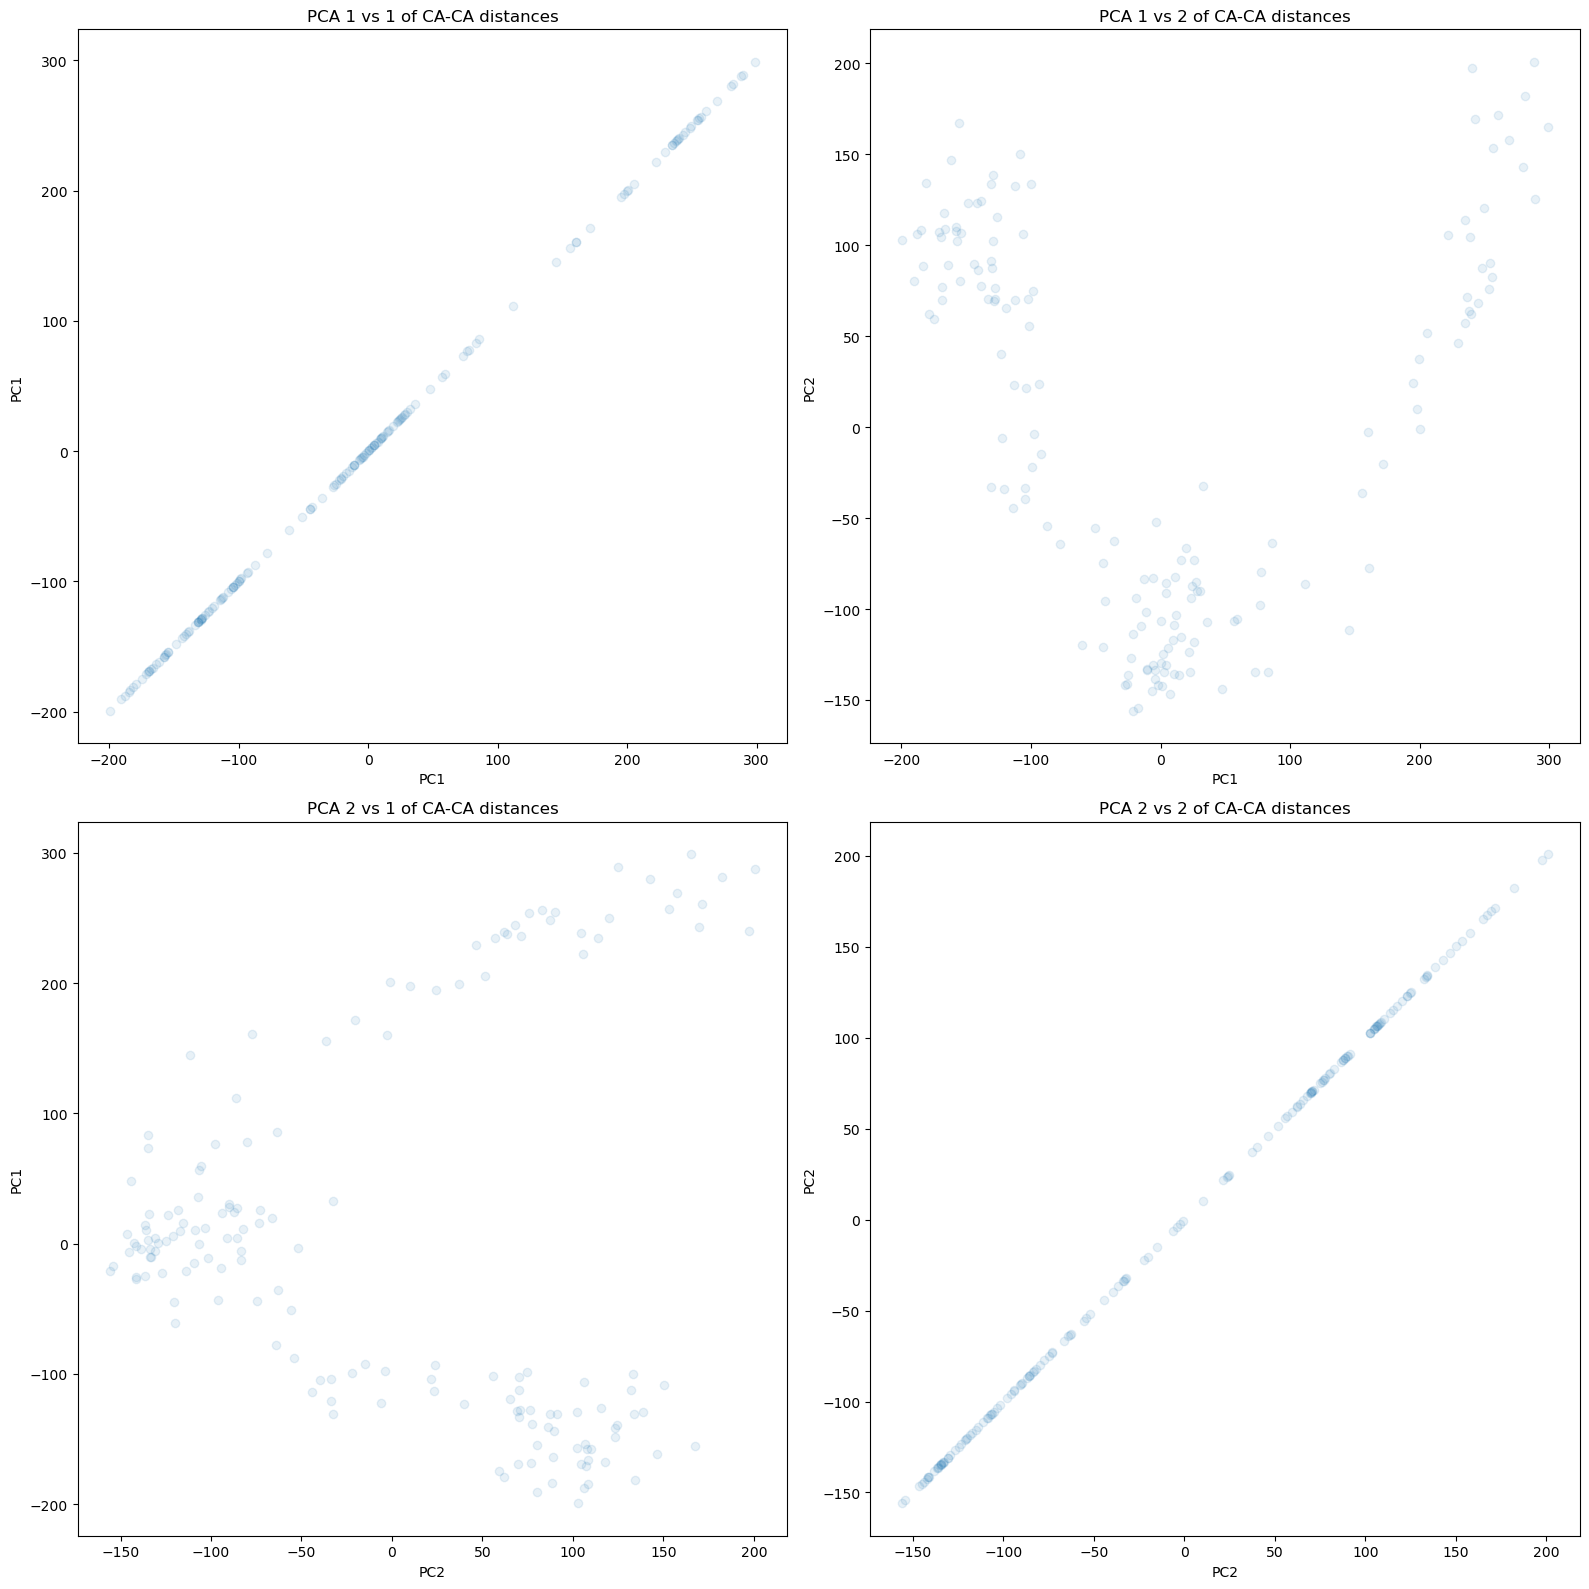

In [25]:
# Create subplots for different combinations of PC(x) vs PC(y)
fig, axs = plt.subplots(n, n, figsize=(16, 16))

# Iterate through all combinations of PC(x) vs PC(y)
for x in range(n):
    for y in range(n):
        #if x != y:
            pc_x = projected_data[:, x]
            pc_y = projected_data[:, y]

            # Plot PC(x) vs PC(y)
            axs[x, y].scatter(pc_x, pc_y, alpha=0.1)
            axs[x, y].set_xlabel(f'PC{x + 1}')
            axs[x, y].set_ylabel(f'PC{y + 1}')
            axs[x, y].set_title(f'PCA {x + 1} vs {y + 1} of CA-CA distances')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [26]:
from sklearn.cluster import KMeans  # You can choose a different clustering algorithm as well

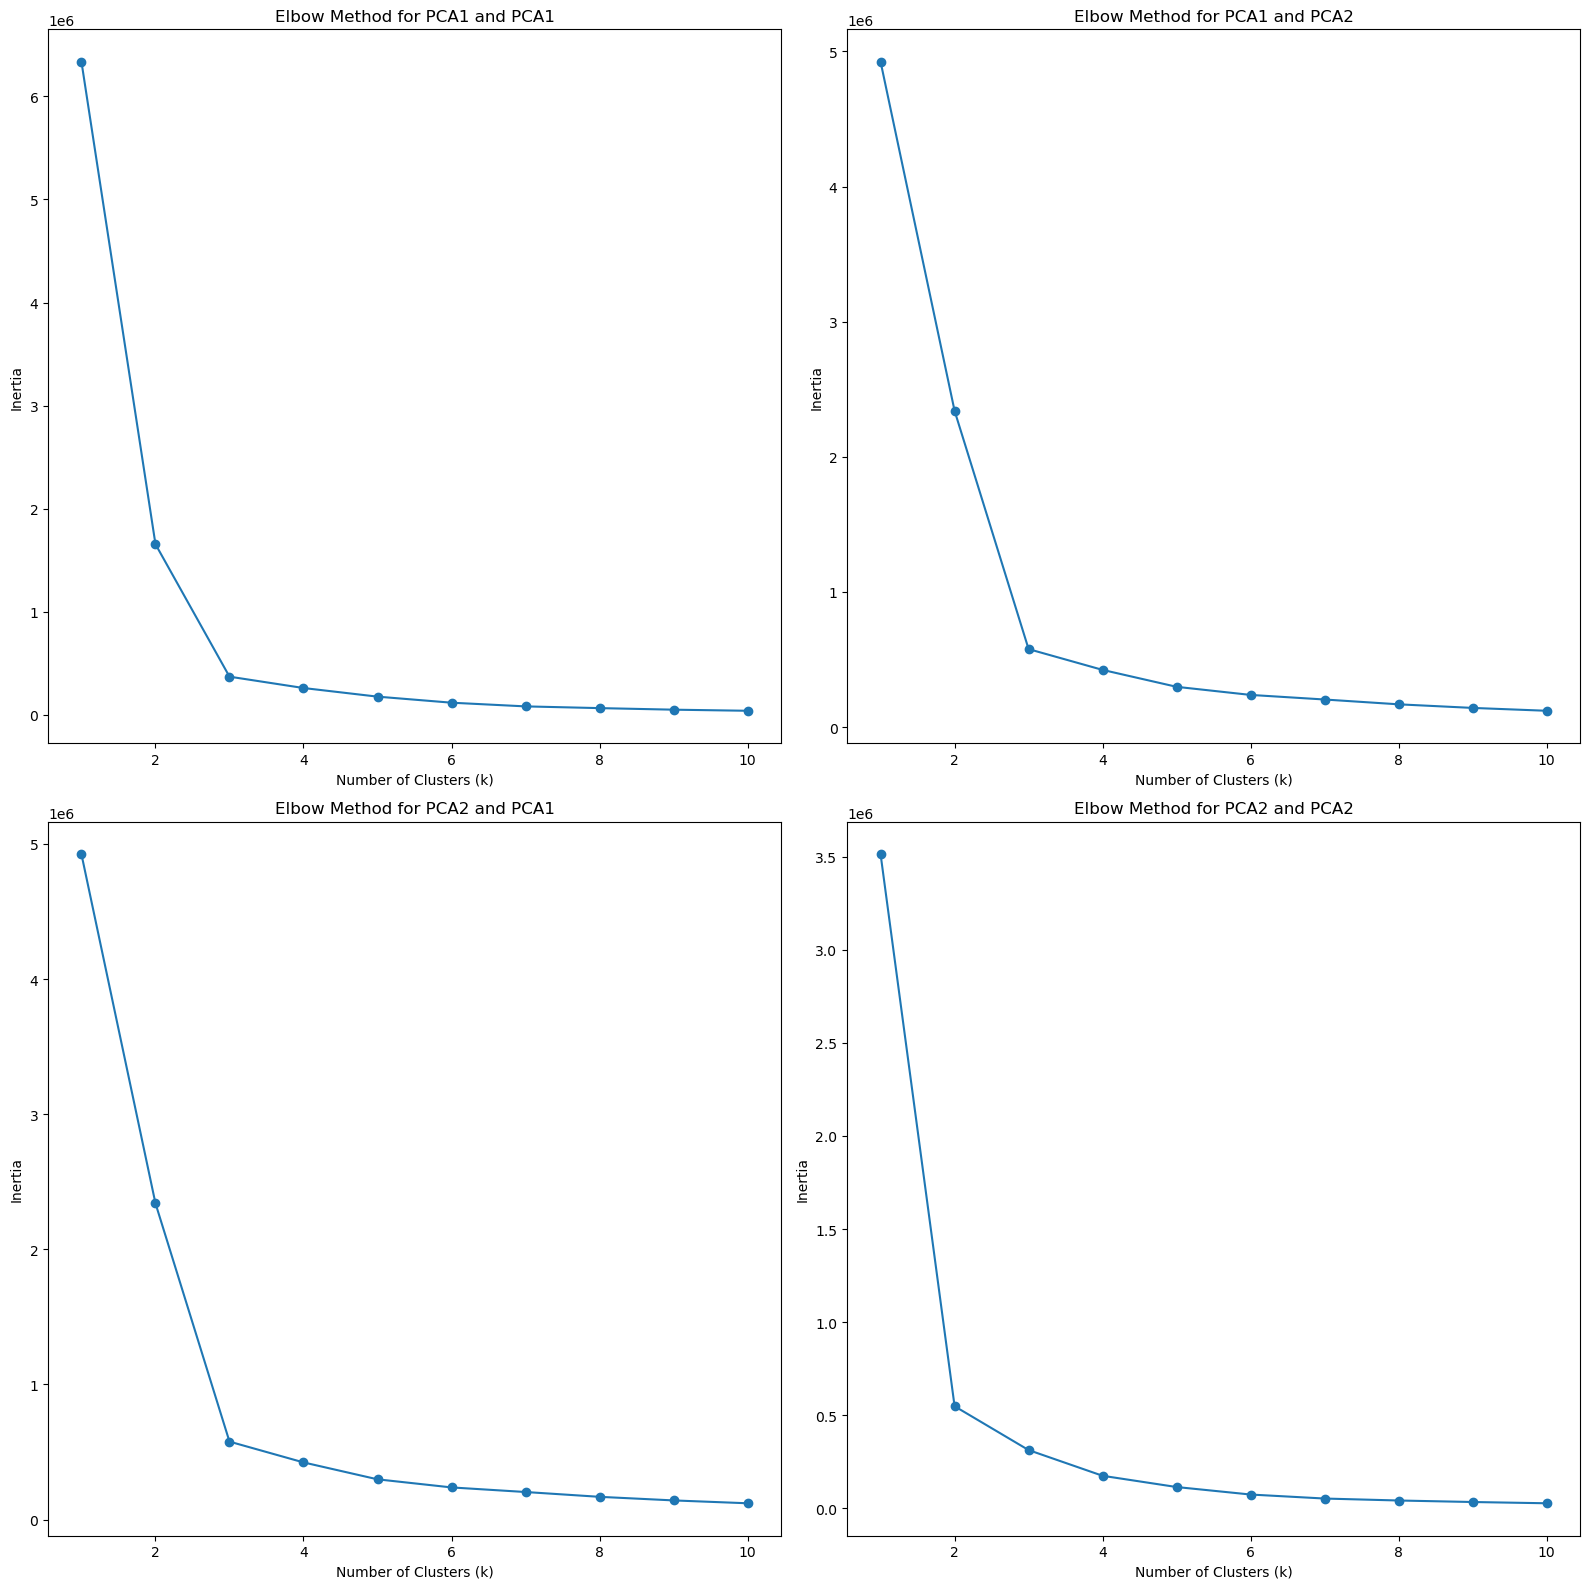

In [28]:
#Elbow method
# Number of clusters you want to create
num_clusters = 3  # Adjust this according to your data

# Create subplots for the elbow method
fig_elbow, axs_elbow = plt.subplots(n, n, figsize=(16, 16))

# Define a range of k values to test (number of clusters)
k_range = range(1, 11)  # Adjust the range as needed

# Iterate through all combinations of PCA components
for x in range(n):
    for y in range(n):
        # Combine PCA components into a feature matrix
        X = projected_data[:, [x, y]]
        
        # Perform the elbow method for this combination of PCA components
        inertia_values = []
        for k in k_range:
            kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
            kmeans.fit(X)
            inertia_values.append(kmeans.inertia_)
        
        # Plot the elbow method results in a separate subplot
        axs_elbow[x, y].plot(k_range, inertia_values, marker='o')
        axs_elbow[x, y].set_xlabel('Number of Clusters (k)')
        axs_elbow[x, y].set_ylabel('Inertia')
        axs_elbow[x, y].set_title(f'Elbow Method for PCA{x + 1} and PCA{y + 1}')

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()

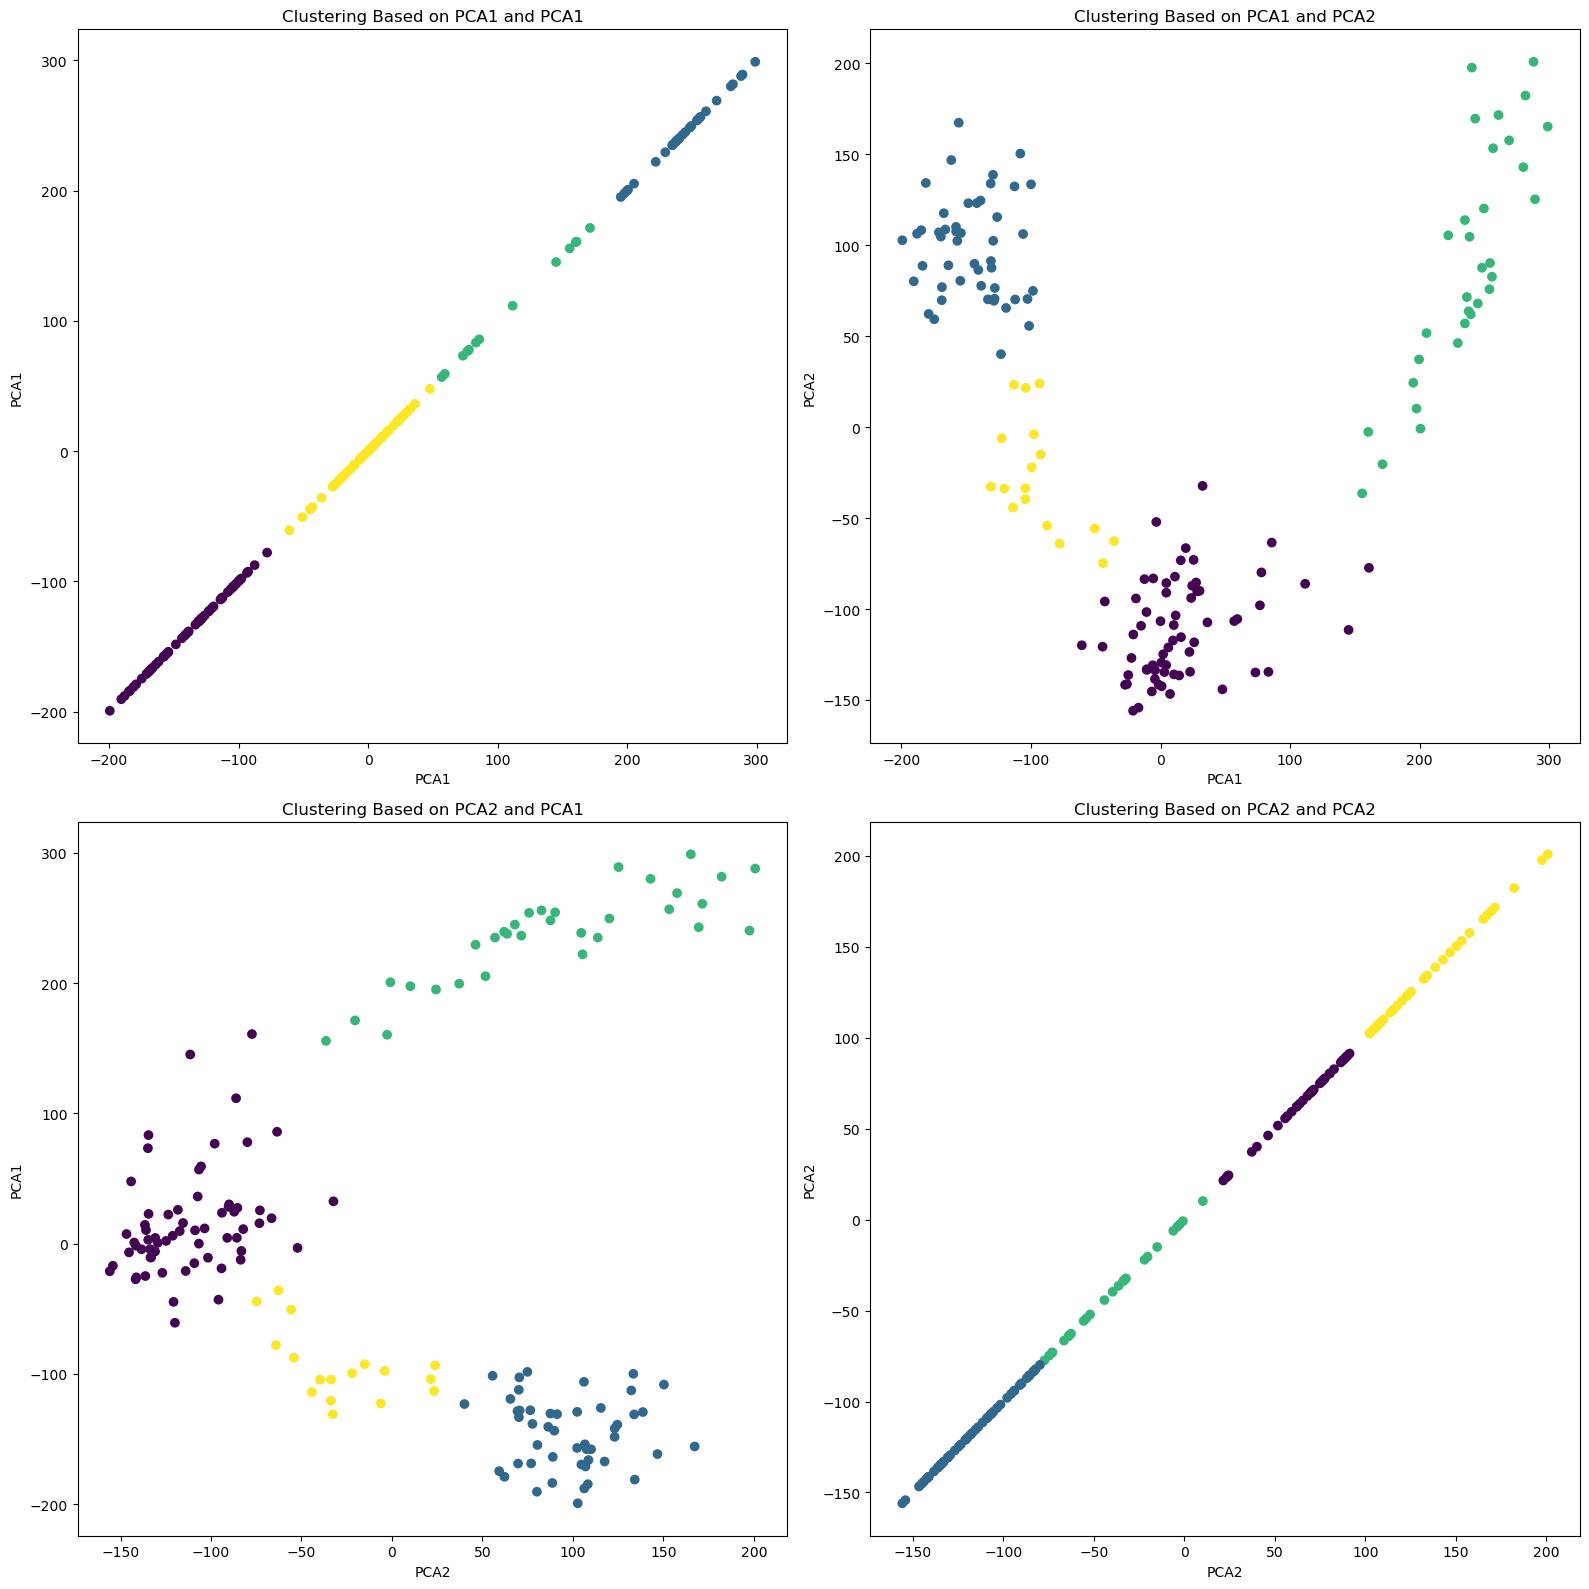

In [30]:
#According to "Elbow point, choose number of clusters"
# Number of clusters you want to create
num_clusters = 4  # Adjust this according to your data

# Create subplots
fig, axs = plt.subplots(n, n, figsize=(16, 16))

# Iterate through all combinations of PCA components
for x in range(n):
    for y in range(n):
        # Combine PCA components into a feature matrix
        X = projected_data[:, [x, y]]
        
        # Initialize the clustering algorithm
        kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=0)
        
        # Fit the clustering model to your data
        kmeans.fit(X)
        
        # Get cluster assignments for each data point
        cluster_labels = kmeans.labels_
        
        # Create a scatter plot with points colored by cluster
        axs[x, y].scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='viridis')
        axs[x, y].set_xlabel(f'PCA{x + 1}')
        axs[x, y].set_ylabel(f'PCA{y + 1}')
        axs[x, y].set_title(f'Clustering Based on PCA{x + 1} and PCA{y + 1}')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [42]:
import os

# Saving PDB structures 

# Define the PCA components you want to analyze (replace with your desired values)
target_pca_x = 0  # Replace with the desired PCA component (0 for PCA1)
target_pca_y = 1  # Replace with the desired PCA component (1 for PCA2)

# Number of clusters you have
num_clusters = len(np.unique(cluster_labels))

# Create output directory for PDB files (modify as needed)
output_directory = 'cluster_representatives_test'
os.makedirs(output_directory, exist_ok=True)

# Load the trajectory
trajs = md.load('traj_inactive.xtc', top='inactive.gro', stride=1000)

# Initialize an array to store reference structures (mean structures of each cluster)
ref_structures = []

# Iterate through clusters and find representatives
for cluster_id in range(num_clusters):
    cluster_mask = cluster_labels == cluster_id

    # Extract frames in the cluster
    cluster_frames = trajs[cluster_mask]

    # Calculate the mean structure of the cluster
    mean_structure = cluster_frames.xyz.mean(axis=0)
    
    # Create a Trajectory object for the mean structure
    ref_structure = md.Trajectory(mean_structure, trajs.top)
    ref_structures.append(ref_structure)

# Now, ref_structures contains the mean structures of each cluster
# Iterate through clusters again to find the closest frame to the mean structure
for cluster_id in range(num_clusters):
    cluster_mask = cluster_labels == cluster_id

    # Extract frames in the cluster
    cluster_frames = trajs[cluster_mask]

    # Initialize variables to track the closest frame
    min_rmsd = None
    closest_frame = None

    # Calculate the RMSD of each frame to the reference structure
    for frame in cluster_frames:
        rmsd = md.rmsd(ref_structures[cluster_id], frame)[0]
        
        # Update the closest frame
        if min_rmsd is None or rmsd < min_rmsd:
            min_rmsd = rmsd
            closest_frame = frame

    # Save the closest frame as a PDB file
    pdb_filename = f'{output_directory}/PCA_{target_pca_x+1}_PCA_{target_pca_y+1}_cluster_{cluster_id}_closest_structure.pdb'
    closest_frame.save(pdb_filename)